In [3]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import skmisc
import anndata
import numpy as np
scvi.settings.seed = 0
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import time

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a fu

# Convenience functions

In [104]:
def scVI_workflow(ad,samplename,sampledir,batch_key='SampleID',n_top_genes=2000,max_epochs=300):
    
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')

    try:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True,batch_key=batch_key)
    except:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True)
    scvi.model.SCVI.setup_anndata(ad, layer=None, batch_key=batch_key)
    model = scvi.model.SCVI(ad, n_latent=10, dispersion='gene', gene_likelihood='nb')
    model.train(max_epochs=max_epochs, accelerator='gpu', plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    Z_hat = model.get_latent_representation()
    model_dir=f'./scvi/{samplename}'
    model.save(model_dir, save_anndata=False)

    SCVI_LATENT_KEY = "X_scVI"
    
    ad.obsm[SCVI_LATENT_KEY] = Z_hat
    sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY, n_neighbors=25)
    t1=time.time()
    sc.tl.leiden(ad, key_added="leiden_scVI_02", resolution=0.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_04", resolution=0.4)
    sc.tl.leiden(ad, key_added="leiden_scVI_06", resolution=0.6)
    sc.tl.leiden(ad, key_added="leiden_scVI_08", resolution=0.8)
    sc.tl.leiden(ad, key_added="leiden_scVI_10", resolution=1.0)
    sc.tl.leiden(ad, key_added="leiden_scVI_12", resolution=1.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_14", resolution=1.4)
    t2=time.time()
    print('clustering time: '+str(t2-t1))

    sc.tl.umap(ad, min_dist=0.3)

    ad_allgenes=sc.read_h5ad(f'{sampledir}/{samplename}.h5ad.gz')
    for key in ad.obs.keys():
        ad_allgenes.obs[key]=ad.obs[key]
    for key in ad.uns.keys():
        ad_allgenes.uns[key]=ad.uns[key]
    for key in ad.obsm.keys():
        ad_allgenes.obsm[key]=ad.obsm[key]
    for key in ad.obsp.keys():
        ad_allgenes.obsp[key]=ad.obsp[key]
    ad=ad_allgenes.copy()
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    return ad

# Unfiltered data checks

Check the presence of putative XIST (LOC106995245) in the cynomolgus heart. However, mere absence in the male heart is not indicative. As a control, we also check male and female liver samples.

In [214]:
samp_dir='/home/gennady/curation-results/qu/kb_out_nac/counts_unfiltered/'
ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
ad.var.index = genes
ad.obs.index = bcs
ad_heart_m = ad.copy()

samp_dir='/home/gennady/curation-results/qu/kb_out_nac_liver_female/counts_unfiltered/'
ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
ad.var.index = genes
ad.obs.index = bcs
ad_liver_f = ad.copy()

samp_dir='/home/gennady/curation-results/qu/kb_out_nac_liver_male/counts_unfiltered/'
ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
ad.var.index = genes
ad.obs.index = bcs
ad_liver_m = ad.copy()

In [247]:
ad_liver_f[:,'LOC106995245'].X.sum()

11104.0

In [248]:
ad_liver_m[:,'LOC106995245'].X.sum()

187.0

In [250]:
ad_heart_m[:,'LOC106995245'].X.sum()

1.0

In the heart, putative XIST is essentially absent. In the liver, it is quite abundant in the female samples and fairly rare in the male. The separation is a bit less striking than in human heart, but this is at least suggestive.

# Clustering

But note that it may just be that the cell type is too rare and was not observed. In fact, Qu et al. Supp Fig. 3 does not actually report neurons. To check if they are present, recluster the (filtered) data using an scVI embedding. 

In [293]:
scvi.__version__

'1.0.4'

In [251]:
samp_dir='/home/gennady/curation-results/qu/kb_out_nac/counts_filtered/'
ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
ad.var.index = genes
ad.obs.index = bcs

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [02:15<00:00,  1.09it/s, v_num=1, train_loss_step=247, train_loss_epoch=257]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [02:15<00:00,  1.11it/s, v_num=1, train_loss_step=247, train_loss_epoch=257]
clustering time: 14.667284488677979


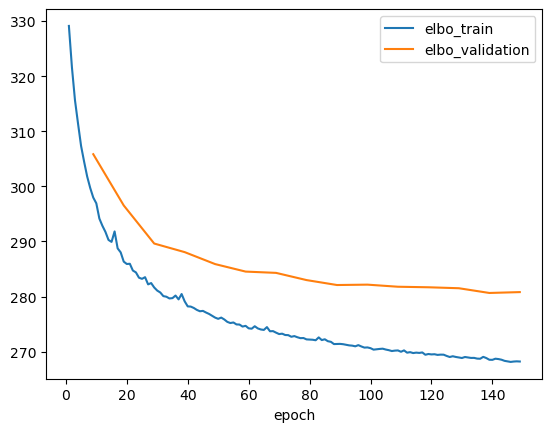

In [252]:
ad_scVI=scVI_workflow(ad,'gg_250910_macfas_heart_qu_nac','/home/gennady/curation-results/qu/scVI/',batch_key=None,
                     n_top_genes=1000,max_epochs=150)

In [21]:
ad=sc.read_h5ad('/home/gennady/curation-results/qu/scVI/gg_250910_macfas_heart_qu_nac.h5ad.gz')

In [22]:
ad

AnnData object with n_obs × n_vars = 12891 × 38551
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [23]:

ad.raw=ad.copy()
sc.pp.log1p(ad)

In [25]:
# ad

In [28]:
sc.tl.rank_genes_groups(ad, groupby='leiden_scVI_02', groups='all',reference='rest',use_raw=False,method='t-test')

In [29]:
sc.tl.dendrogram(ad,groupby='leiden_scVI_02',use_rep='X_scVI')

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


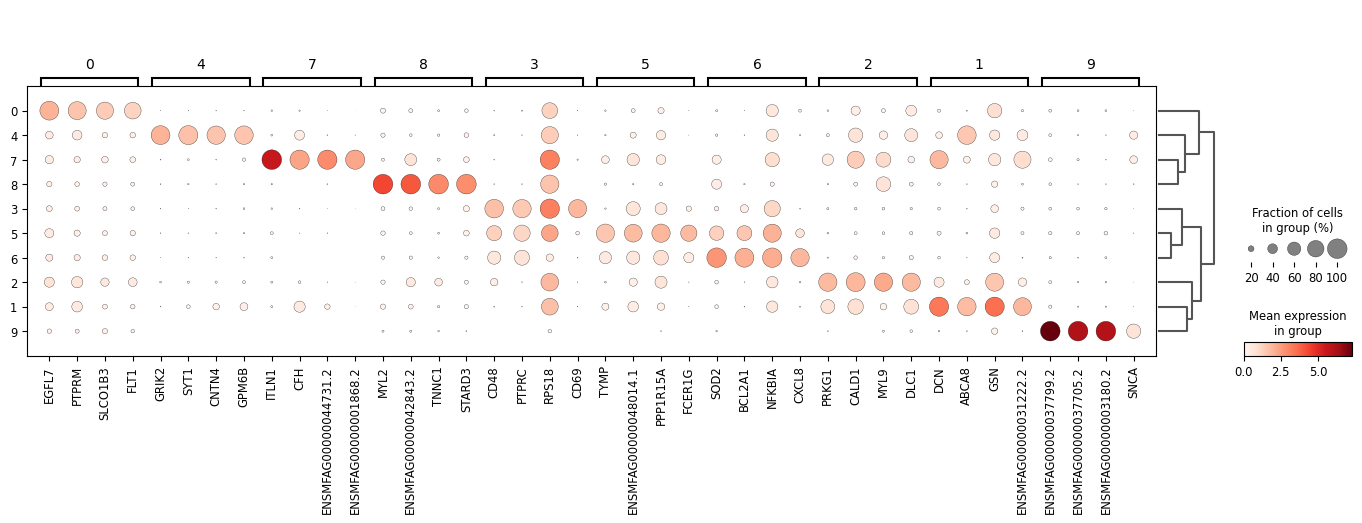

In [30]:
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


In [10]:
de=sc.get.rank_genes_groups_df(ad,group='4')
de.set_index('names',inplace=True)

In [11]:
de.loc[['PLP1','MPZ','SCN7A']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
PLP1,16.381399,6.430652,1.111992e-43,2.154192e-41
MPZ,14.664959,8.250214,3.401392e-37,4.356381e-35
SCN7A,28.005665,3.868472,5.460772e-87,1.238342e-83


In [12]:
ad.raw[:,'LOC106995245'].X.sum()

0.0

In [13]:
ad.obs['leiden_scVI_02'].value_counts()

leiden_scVI_02
0    7639
1    2300
2    1316
3     654
4     305
5     268
6     211
7      72
8      68
9      58
Name: count, dtype: int64

In [14]:
de[:15]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
GRIK2,40.719574,9.307359,3.518810e-125,6.782682e-121
SYT1,40.031498,7.322587,2.217876e-123,2.850045e-119
CNTN4,35.648983,6.327509,8.176876e-111,7.880669e-107
GPM6B,34.215858,5.883018,1.642007e-106,1.266020e-102
NRN1,33.653202,6.112319,1.062478e-104,5.851371e-101
XKR4,33.606628,8.704039,2.040284e-104,8.739445e-101
CADM1,32.438801,6.161225,6.568984e-101,2.302190e-97
CDH19,32.136017,6.356997,6.295645e-100,2.022528e-96
ENSMFAG00000065365.1,31.050055,8.740370,2.583434e-96,7.661074e-93


The clustering is even clear on a UMAP, because the cell type is very distinct and reproducible.

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


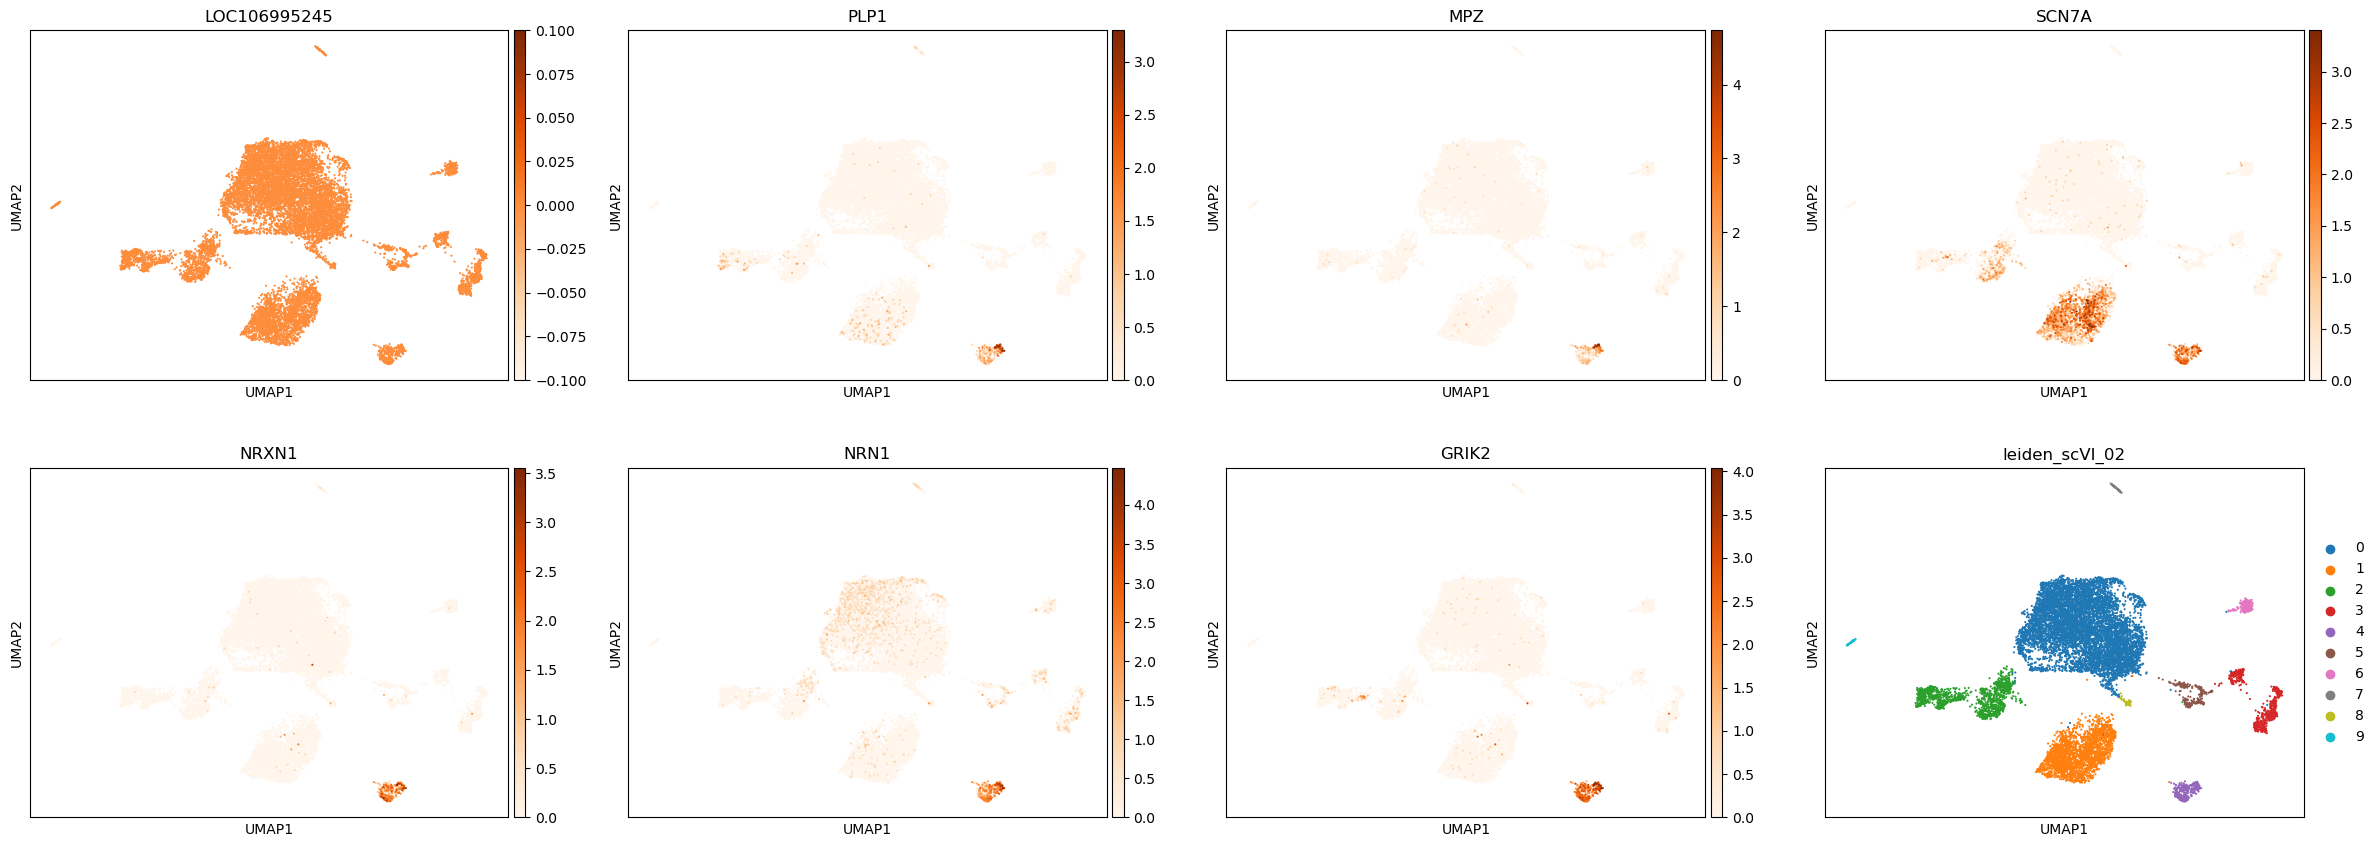

In [18]:
sc.pl.umap(ad,color=['LOC106995245','PLP1','MPZ','SCN7A','NRXN1','NRN1','GRIK2','leiden_scVI_02'],use_raw=False, cmap='Oranges')